# Text Classification

### Goal: Given a set of text movie reviews that have been labeled negative or positive

For more information on this dataset visit http://ai.stanford.edu/~amaas/data/sentiment/



## Data Preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(filepath_or_buffer='../DATA/moviereviews.csv')

In [3]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2000 non-null   object
 1   review  1965 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [5]:
#Drop the missing items 
df.dropna(inplace=True)

In [6]:
# There are 27 empty strings 
(df['review'].str.strip().apply(len) == 0 ).sum()

#Lets drop them 
df.drop(index = df[df['review'].str.strip().apply(len) == 0 ].index, inplace=True) 

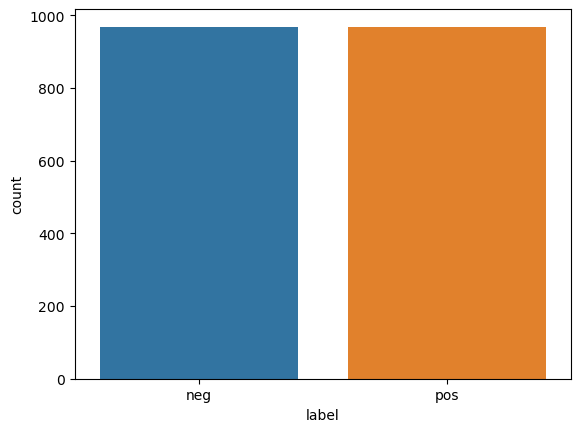

In [7]:
# Let's see of it is balanced 
sns.countplot(data=df, x='label');

In [8]:
df['label'].value_counts()

label
neg    969
pos    969
Name: count, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1938 non-null   object
 1   review  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


## EDA on the bag of words 

In [10]:
## Let's see most repeated words in positive reviews ignoring stop words
def get_n_repeated(content, n: int = 20, decending : bool= True) -> list:
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer  = CountVectorizer(stop_words='english')
    sparce_matrix = vectorizer.fit_transform(content)
    frequency = sparce_matrix.sum(axis=0)
    word_freq_table = []
    
    for word, idx in  vectorizer.vocabulary_.items():
        word_freq_table.append((word,  frequency[0, idx]))
    if decending:
        return sorted(word_freq_table, key= lambda mob: -1* mob[1])[0:n]
    else:
        return sorted(word_freq_table, key= lambda mob: -1* mob[1])[-1*n:]

get_n_repeated(df[df['label'] == 'pos']['review'])

[('film', 5002),
 ('movie', 2389),
 ('like', 1721),
 ('just', 1273),
 ('story', 1199),
 ('good', 1193),
 ('time', 1175),
 ('character', 1037),
 ('life', 1032),
 ('characters', 957),
 ('way', 864),
 ('films', 851),
 ('does', 828),
 ('best', 788),
 ('people', 769),
 ('make', 764),
 ('little', 751),
 ('really', 731),
 ('man', 728),
 ('new', 702)]

In [11]:
get_n_repeated(df[df['label'] == 'neg']['review'])

[('film', 4063),
 ('movie', 3131),
 ('like', 1808),
 ('just', 1480),
 ('time', 1127),
 ('good', 1117),
 ('bad', 997),
 ('character', 926),
 ('story', 908),
 ('plot', 888),
 ('characters', 838),
 ('make', 813),
 ('really', 743),
 ('way', 734),
 ('little', 696),
 ('don', 683),
 ('does', 666),
 ('doesn', 648),
 ('action', 635),
 ('scene', 634)]

## Preprocessing and Model Selection

In [12]:
from sklearn.model_selection import train_test_split
X = df['review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = make_pipeline(TfidfVectorizer(stop_words='english'),KNeighborsClassifier(n_jobs=-1))
pipe_log = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(n_jobs=-1, max_iter= 10 ** 8, penalty='elasticnet', solver='saga'))
pipe_rf = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier(n_jobs=-1))
pipe_nb = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())
pipe_svm = make_pipeline(TfidfVectorizer(stop_words='english'), LinearSVC())


In [14]:
parm_log = {'logisticregression__C': np.logspace(-4,4,11) , 'logisticregression__l1_ratio':[0 ,0.1, 0.5, 0.9, 0.99] }
parm_rf = {'randomforestclassifier__n_estimators': np.arange(80,121) ,'randomforestclassifier__criterion':['gini', 'entropy']}
parm_svm = {'linearsvc__C': np.logspace(-4,4,21)}
parm_nb = {'multinomialnb__alpha': np.arange(1,10,1)}
parm_knn = {'kneighborsclassifier__n_neighbors': np.arange(1,20,1)}

In [15]:
from sklearn.model_selection import GridSearchCV

grid_knn = GridSearchCV(cv=5, n_jobs=-1, estimator=pipe_knn, param_grid=parm_knn , scoring='accuracy', verbose=2)
grid_log = GridSearchCV(cv=5, n_jobs=-1, estimator=pipe_log, param_grid=parm_log , scoring='accuracy', verbose=2)
grid_rf = GridSearchCV(cv=5, n_jobs=-1, estimator=pipe_rf, param_grid=parm_rf , scoring='accuracy', verbose=2)
grid_svm = GridSearchCV(cv=5, n_jobs=-1, estimator=pipe_svm, param_grid=parm_svm , scoring='accuracy', verbose=2)
grid_nb = GridSearchCV(cv=5, n_jobs=-1, estimator=pipe_nb, param_grid=parm_nb , scoring='accuracy', verbose=2)



In [16]:
import os
from joblib import dump, load  
def check_and_load(grid: GridSearchCV = None, filename: str = None) -> GridSearchCV:
    if filename in os.listdir('./learners/'):
        grid = load(filename=f'./learners/{filename}')
        return grid
    else:
        grid.fit(X_train, y_train)
        dump(grid, filename=f'./learners/{filename}')
    return grid

grid_knn = check_and_load(grid_knn, 'knn.joblib')
grid_log = check_and_load(grid_log, 'log.joblib')
grid_rf = check_and_load(grid_rf, 'rf.joblib')
grid_svm = check_and_load(grid_svm, 'svm.joblib')
grid_nb = check_and_load(grid_nb, 'nb.joblib')

estimators = [grid_knn, grid_log, grid_rf, grid_svm, grid_nb]
estimators_name = [list(x.estimator.named_steps.keys())[-1] for x in estimators ]

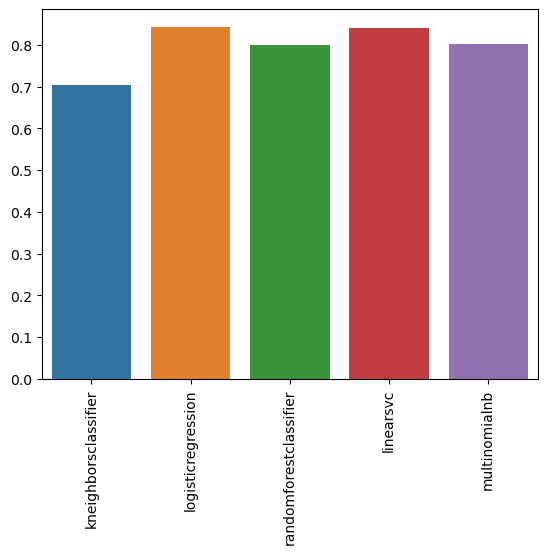

In [17]:
# Cross validation erros
sns.barplot(x=estimators_name, y=[x.best_score_ for x in estimators])
plt.xticks(rotation = 90);

Clearly, everything accept knn have good validation test error rate! what about test error rate on holdout set?

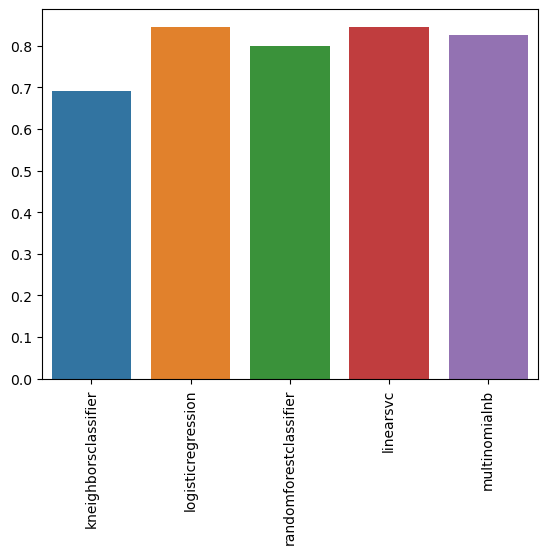

In [18]:
from sklearn.metrics import accuracy_score
sns.barplot(x=estimators_name, y=[accuracy_score(y_test,  x.predict(X_test)) for x in estimators])
plt.xticks(rotation = 90);

Very similar results! Let's discard KNN and make a meta voting classifier from the other estimators

In [19]:
#Remove the KNN
estimators.pop(0)
estimators_name.pop(0)

'kneighborsclassifier'

In [23]:
from sklearn.ensemble import VotingClassifier
meta_learner = VotingClassifier(estimators=list(zip(estimators_name, [x.best_estimator_ for x in estimators])), voting='hard', n_jobs=-1)
meta_learner.fit(X_train, y_train)

VotingClassifier(estimators=[('logisticregression',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('logisticregression',
                                               LogisticRegression(C=39.81071705534978,
                                                                  l1_ratio=0,
                                                                  max_iter=100000000,
                                                                  n_jobs=-1,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))])),
                             ('randomforestclassifier',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_wo...
                                              ('randomforestclassifier',
                                               RandomForestClassifier(criterion='entropy',
                                                                      n_estimators=111,
                                                                      n_jobs=-1))])),
                             ('linearsvc',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('linearsvc', LinearSVC())])),
                             ('multinomialnb',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('multinomialnb',
                                               MultinomialNB(alpha=1))]))],
                 n_jobs=-1)

Let's test the accuracy of this meta learner 

In [24]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
def report(model):
    print(classification_report(y_true=y_test , y_pred=model.predict(X_test)))
    ConfusionMatrixDisplay(None).from_estimator(estimator=model, X=X_test, y=y_test)

              precision    recall  f1-score   support

         neg       0.81      0.88      0.84       188
         pos       0.88      0.80      0.84       200

    accuracy                           0.84       388
   macro avg       0.84      0.84      0.84       388
weighted avg       0.84      0.84      0.84       388



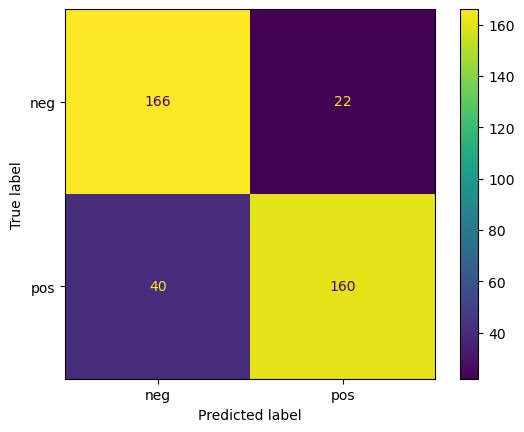

In [25]:
report(meta_learner)

What about others learner?

              precision    recall  f1-score   support

         neg       0.69      0.65      0.67       188
         pos       0.69      0.73      0.71       200

    accuracy                           0.69       388
   macro avg       0.69      0.69      0.69       388
weighted avg       0.69      0.69      0.69       388



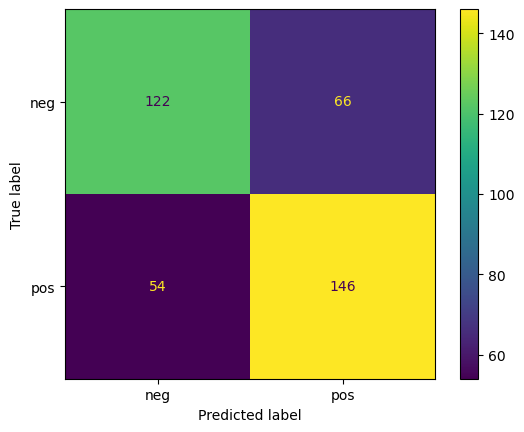

In [26]:
report(grid_knn)

              precision    recall  f1-score   support

         neg       0.84      0.84      0.84       188
         pos       0.85      0.85      0.85       200

    accuracy                           0.85       388
   macro avg       0.85      0.85      0.85       388
weighted avg       0.85      0.85      0.85       388



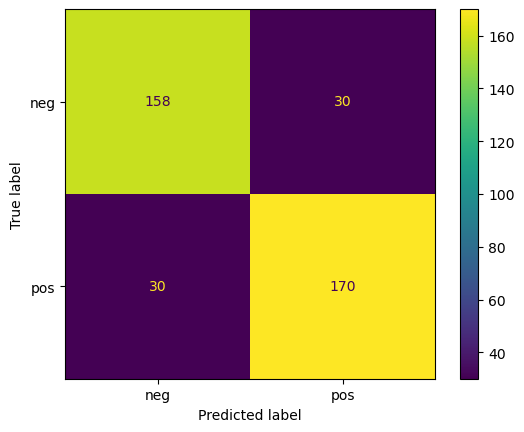

In [27]:
report(grid_log)

              precision    recall  f1-score   support

         neg       0.85      0.83      0.84       188
         pos       0.84      0.86      0.85       200

    accuracy                           0.85       388
   macro avg       0.85      0.84      0.85       388
weighted avg       0.85      0.85      0.85       388



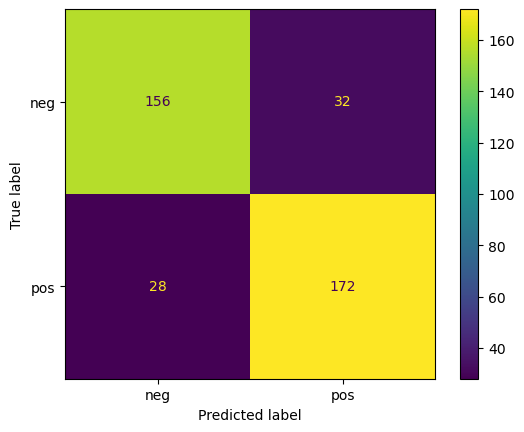

In [28]:
report(grid_svm)

              precision    recall  f1-score   support

         neg       0.76      0.86      0.81       188
         pos       0.85      0.74      0.79       200

    accuracy                           0.80       388
   macro avg       0.80      0.80      0.80       388
weighted avg       0.81      0.80      0.80       388



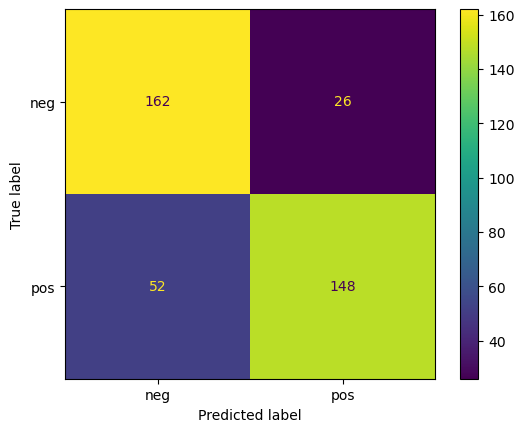

In [29]:
report(grid_rf)

              precision    recall  f1-score   support

         neg       0.79      0.88      0.83       188
         pos       0.87      0.78      0.82       200

    accuracy                           0.82       388
   macro avg       0.83      0.83      0.82       388
weighted avg       0.83      0.82      0.82       388



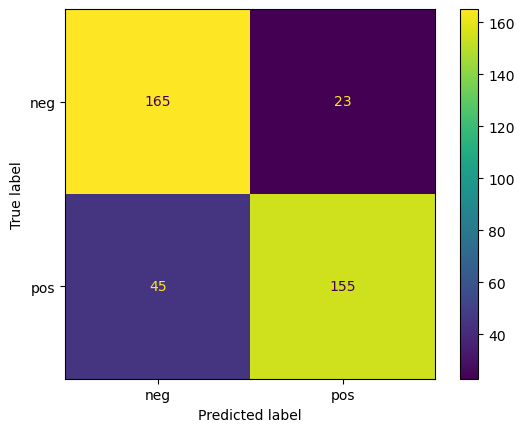

In [30]:
report(grid_nb)

In [48]:
meta_learner.predict(['good movie'])

array(['pos'], dtype=object)

## Deployment 

In [49]:
meta_learner.fit(X, y)

VotingClassifier(estimators=[('logisticregression',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('logisticregression',
                                               LogisticRegression(C=39.81071705534978,
                                                                  l1_ratio=0,
                                                                  max_iter=100000000,
                                                                  n_jobs=-1,
                                                                  penalty='elasticnet',
                                                                  solver='saga'))])),
                             ('randomforestclassifier',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_wo...
                                              ('randomforestclassifier',
                                               RandomForestClassifier(criterion='entropy',
                                                                      n_estimators=111,
                                                                      n_jobs=-1))])),
                             ('linearsvc',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('linearsvc', LinearSVC())])),
                             ('multinomialnb',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('multinomialnb',
                                               MultinomialNB(alpha=1))]))],
                 n_jobs=-1)

In [52]:
dump(meta_learner, filename='./learners/meta_learner_deploy.joblib')

['./learners/meta_learner_deploy.joblib']